### Setup

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense , GRU , SimpleRNN

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### The weather dataset

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

# We will just deal with hourly predictions, so we'll sub-sampling the data from 10-minute intervals to one-hour intervals:

df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

13568290/13568290 [==============================] - 0s 0us/step


#### Glance at data

In [ ]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


### Inspecting the statistics of data

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


- This -9999 is likely erroneous.

- There's a separate wind direction column, so the velocity should be greater than zero (>=0). Replace it with zeros:

In [ ]:
wv = df['wv (m/s)']  # First we have stored the wv column into a variable 'wv'
bad_wv = wv == -9999.0  # Then we are storing this boolean condition (not it's reasult) into bad_wv variable
wv[bad_wv] = 0.0  # Now we are checking in wv column , where this condition becomes true it means element is -9999.0 , there we'll store 0.0 value

# Similar Process we are applying to "max. wv" column and substituting the error value will 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# Checking if the above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

### Feature Enginnering

- Process of extracting desired data from the given raw data.
- That desired data containes the limited features which will give us desired output

- The last column of the data, wd (deg)—gives the wind direction in units of degrees. Angles do not make good model inputs because:

  - Angles are typically measured in degrees or radians, which are continuous and cyclic values.Machine learning models often work better with numerical features that have a linear scale and can be represented as real numbers.

  - Representing angles as continuous variables can cause a loss of information due to their cyclic nature.

    - For example, if an angle wraps around from 359 degrees to 0 degrees, the model might interpret it as a significant change rather than a small difference. This can lead to incorrect interpretations and predictions.


In [ ]:
# The following 2 lines removes the column with the label 'wv (m/s)' and 'max. wv (m/s)' from the DataFrame 'df' and assigns it to the variable 'wv' and 'max_wv' resptvely.
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180  # THis line also removes the column and storing it in variable after performing opr to convert into radians

# Calculate the wind x and y components and storing it in new columns 'Wx' and 'Wy'
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components and storing it in new columns 'Wx' and 'Wy'
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

In [ ]:
df.head()
# df.head()
features = ['p (mbar)','T (degC)','Tpot (K)','Tdew (degC)','rh (%)','VPmax (mbar)','VPact (mbar)' ,'VPdef (mbar)','sh (g/kg)','H2OC (mmol/mol)','rho (g/m**3)','Wx','Wy','max Wx','max Wy']
len(features)

15

## Splitting of Data in 70:20:10 for ( training , validation , testing ) sets

In [ ]:
# The result is a dictionary, column_indices, where the keys are the column names of df, and the values are their respective indices in the column list.
# This dictionary can be used to quickly access the index of a column based on its name, which can be useful for various oprs such as column rearrangement,selec. or manip.
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

## Normalize the data

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
train_df.size

735945

## Data Windowing

- The purpose of data windowing is to break down a larger dataset into smaller, more manageable chunks that can be analyzed or processed individually.

- By segmenting the time series into smaller windows, it becomes possible to analyze each segment independently and extract relevant features or characteristics. This can be useful for tasks such as trend analysis, anomaly detection, or forecasting.



### ***- Indexes and offsets***

In [ ]:
# input_width: The number of time steps in the input window.
# label_width: The number of time steps in the output/label window.
# shift: The number of time steps to shift the window for the next prediction. Here we will move data by 24 (we'll take the data of each day as a subsequence)
# train_df, val_df, test_df: DataFrames containing the training, validation, and testing data.
# label_columns: A list of column names that represent the output/label variables.

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)  # This will create slice object slice(0, input_width, None)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]  # input_indices will contain indeces from 0 to input_width (instead of till total_window_size)

    self.label_start = self.total_window_size - self.label_width # starting index of output / label / prediction
    self.labels_slice = slice(self.label_start, None)   # This will create slice object slice(label_start, None, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice] # label_indices contains indices from label_start to end

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

### ***- Split Window***

- The features tensor is assumed to have a shape of [batch_size, total_window_size, num_features]. The input_slice is a range of indices that specifies which part of the total_window_size to consider as the input window. So this line extracts the input window from the features tensor.

- labels_slice is a range of indices that specifies which part of the total_window_size to consider as the label window.


In [ ]:
def split_window(self, features):

  inputs = features[:, self.input_slice, :]   # : before input_slice says selecting every rows , : after slice says take the third dimension too
  labels = features[:, self.labels_slice, :]

  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.

  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window  # split_window user defined func assigned to method of WindowGenerator class

### ***-Plot***

In [ ]:
# def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
#   inputs, labels = self.example
#   plt.figure(figsize=(12, 8))
#   plot_col_index = self.column_indices[plot_col]
#   max_n = min(max_subplots, len(inputs))
#   for n in range(max_n):
#     plt.subplot(max_n, 1, n+1)
#     plt.ylabel(f'{plot_col} [normed]')
#     plt.plot(self.input_indices, inputs[n, :, plot_col_index],
#              label='Inputs', marker='.', zorder=-10)

#     if self.label_columns:
#       label_col_index = self.label_columns_indices.get(plot_col, None)
#     else:
#       label_col_index = plot_col_index

#     if label_col_index is None:
#       continue

#     plt.scatter(self.label_indices, labels[n, :, label_col_index],
#                 edgecolors='k', label='Labels', c='#2ca02c', s=64)
#     if model is not None:
#       predictions = model(inputs)
#       plt.scatter(self.label_indices, predictions[n, :, label_col_index],
#                   marker='X', edgecolors='k', label='Predictions',
#                   c='#ff7f0e', s=64)

#     if n == 0:
#       plt.legend()

#   plt.xlabel('Time [h]')

# WindowGenerator.plot = plot

### ***Creating tf.data.Datasets***

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,   # It determines how many time steps to skip between two consecutive sequences in the dataset.
      shuffle=True,
      batch_size=32,)
  ds = ds.map(self.split_window)
# By using map(self.split_window), the split_window function is applied to each element of the dataset,
# resulting in a new dataset where each element has been transformed into a tuple of inputs and labels.

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  '''Get and cache an example batch of `inputs, labels` for plotting.'''
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## Single step and Wide Window

In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1 , label_columns = features)

wide_window = WindowGenerator(
    input_width=24, label_width=1, shift=1 , label_columns = features)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 15)
Labels shape (batch, time, features): (32, 1, 15)


## Baseline
- Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 2s 4ms/step - loss: 0.5292 - mean_absolute_error: 0.4806


In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 15)
Output shape: (32, 24, 15)


In [ ]:
# wide_window.plot(baseline)

## Training Procedure

In [ ]:
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

### RNN

In [ ]:
rnn = Sequential()
rnn.add(SimpleRNN(64 , return_sequences=True))
rnn.add(Dense(num_features))

### LSTM

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(Dense(num_features))

### Bi-LSTM

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(10, return_sequences=True)))
model.add(Dense(num_features))

### GRU

In [ ]:
gru_model = Sequential()
gru_model.add(GRU(64,return_sequences=True))
gru_model.add(Dense(num_features))

### Bi-GRU

In [ ]:
bi_gru = Sequential()
bi_gru.add(Bidirectional(GRU(10, return_sequences=True)))
bi_gru.add(Dense(num_features))

--------------------------------------------------------------------------------

## Evaluation Procedure

### Evaluating RNN

In [ ]:
history = compile_and_fit(rnn , wide_window)

IPython.display.clear_output()
val_performance['RNN'] = rnn.evaluate(wide_window.val)
performance['RNN'] = rnn.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 2s 4ms/step - loss: 113.1834 - mean_absolute_error: 0.7022


In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', rnn(wide_window.example[0]).shape)

Input shape: (32, 24, 15)
Output shape: (32, 24, 15)


### Evaluating lstm model

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 2s 5ms/step - loss: 99.4972 - mean_absolute_error: 0.6681


In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 15)
Output shape: (32, 24, 15)


### Evaluating Bi-LSTM model

In [ ]:
history = compile_and_fit(model, wide_window)

IPython.display.clear_output()
val_performance['Bi-LSTM'] = model.evaluate(wide_window.val)
performance['Bi-LSTM'] = model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 3s 6ms/step - loss: 99.4311 - mean_absolute_error: 0.6743


In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', model(wide_window.example[0]).shape)

Input shape: (32, 24, 15)
Output shape: (32, 24, 15)


### Evaluating GRU model

In [ ]:
history = compile_and_fit(gru_model, wide_window)

IPython.display.clear_output()
val_performance['GRU'] = gru_model.evaluate(wide_window.val)
performance['GRU'] = gru_model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 2s 5ms/step - loss: 116.5669 - mean_absolute_error: 0.6824


In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', gru_model(wide_window.example[0]).shape)

Input shape: (32, 24, 15)
Output shape: (32, 24, 15)


### Evaluating Bi-GRU

In [ ]:
history = compile_and_fit(bi_gru, wide_window)

IPython.display.clear_output()
val_performance['Bi-GRU'] = bi_gru.evaluate(wide_window.val)
performance['Bi-GRU'] = bi_gru.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 2s 5ms/step - loss: 117.6151 - mean_absolute_error: 0.6875


In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', bi_gru(wide_window.example[0]).shape)

Input shape: (32, 24, 15)
Output shape: (32, 24, 15)


## Performance

- Here is the overall performance for these multi-output models.



### Graphical Representation

In [ ]:
# wide_window.plot(model)

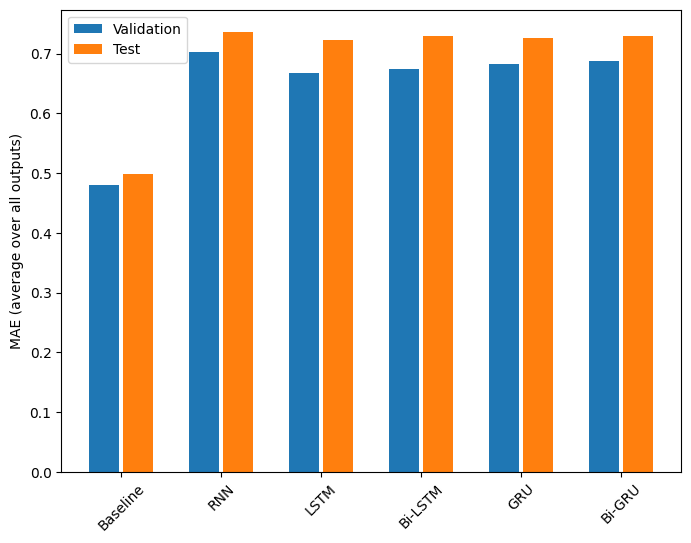

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.4989
RNN            : 0.7366
LSTM           : 0.7229
Bi-LSTM        : 0.7289
GRU            : 0.7266
Bi-GRU         : 0.7292


In [ ]:
predicted = model.predict(wide_window.train)

1533/1533 [==============================] - 9s 5ms/step


In [ ]:
val_ds = wide_window.train
dataset_list = list(val_ds)

actual = np.array([])

count = 0
for i in range(len(dataset_list)):
  for j in range(len(dataset_list[i][1])):
    actual = np.insert(actual ,count, dataset_list[i][1][0][0][0])
    count+=1

In [ ]:
actual = actual.tolist()

In [ ]:
len(actual)

49039

In [ ]:
# len(predicted)
predicted[0][:3]

array([[ 0.02173454, -0.07621515, -0.11294219,  0.02053693,  0.00136727,
        -0.14130567, -0.15584408, -0.04506944, -0.20120451, -0.20420894,
         0.02062155, -0.00318741,  0.01849203,  0.01232276,  0.0051864 ],
       [ 0.01894121, -0.08719854, -0.11984837,  0.01971155,  0.00595818,
        -0.16005363, -0.1931955 , -0.04760669, -0.23855102, -0.22326022,
         0.02443746, -0.00823629,  0.01776023,  0.0097321 ,  0.00810965],
       [ 0.01913434, -0.09062654, -0.12193291,  0.02058789,  0.01168044,
        -0.17493965, -0.22949915, -0.05287379, -0.26821887, -0.23332995,
         0.02908211, -0.01086969,  0.01626143,  0.00823279,  0.01084109]],
      dtype=float32)

In [ ]:
predicted.shape

(49039, 24, 15)

In [ ]:
print("Dataset contains ", len(dataset_list) , " arrays")
print("In every array it contains " ,len(dataset_list[0]) , " elements , Input + Label ")
print("In both the elements there are " , len(dataset_list[0][0]) , " & " , len(dataset_list[0][1]) , " arrays")
print("Inside the 32 arrays in Input element there is array of " , len(dataset_list[0][0][0]) , " elements , which signifies That many hours of previous data is used as input")
print("Inside the 32 arrays in Label element there is array of " , len(dataset_list[0][1][0]) , " element , which signifies That many hours of prediction is done")
print("Inside the 24 arrays in Input element in that each array consists of " , len(dataset_list[0][0][0][0]) , " elements , which signifies number of features")

print("\nLabel can be accessed by " , dataset_list[0][1][0][0][0]) # using 5 dimensions

Dataset contains  1533  arrays
In every array it contains  2  elements , Input + Label 
In both the elements there are  32  &  32  arrays
Inside the 32 arrays in Input element there is array of  24  elements , which signifies That many hours of previous data is used as input
Inside the 32 arrays in Label element there is array of  1  element , which signifies That many hours of prediction is done
Inside the 24 arrays in Input element in that each array consists of  15  elements , which signifies number of features

Label can be accessed by  tf.Tensor(0.40899926, shape=(), dtype=float32)


#### Line Plot

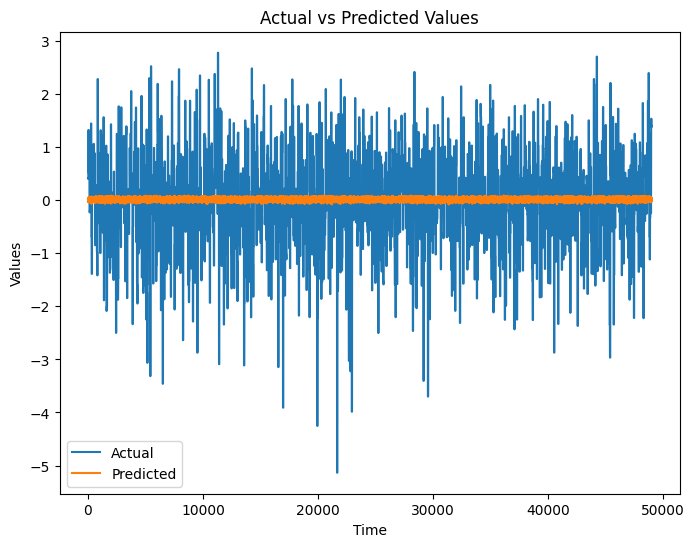

In [ ]:
actual_t = actual
predicted_t = predicted

time_steps = np.arange(len(actual_t))

# Plotting the line plot
plt.plot(time_steps, actual_t, label='Actual')
plt.plot(time_steps, predicted_t[:, 0 , 0], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

#### Scatter plot

In [ ]:
predicted_t = predicted[:100]
predicted_t.shape

(100, 24, 15)

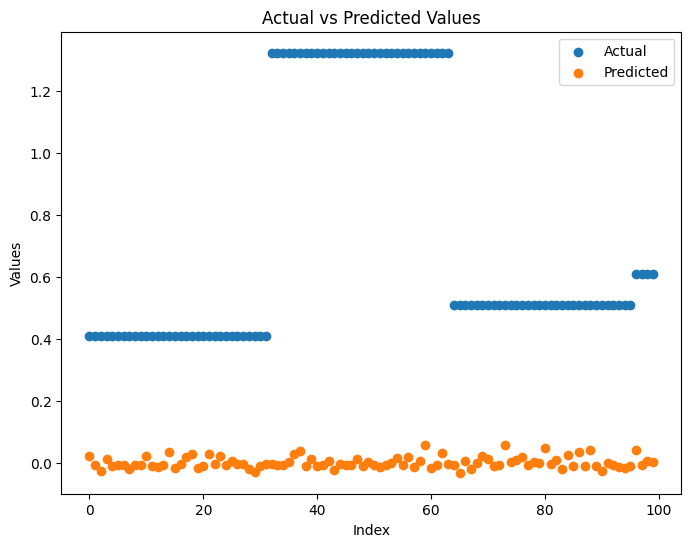

In [ ]:
actual_t = actual[:100]
predicted_t = predicted[:100]

time_steps = np.arange(len(actual_t))

# Plotting the scatter plot
plt.scatter(time_steps, actual_t, label='Actual')
plt.scatter(time_steps, predicted_t[:,0 , 0], label='Predicted')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()